In [1]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from torchvision.datasets import VisionDataset
from IPython.core.debugger import set_trace
    
import torch
from torch.utils.data import Dataset
import torchvision.transforms.v2 as transforms

import numpy as np

class Cows_VOCDataset(VisionDataset):
    def __init__(self, root_dir,label_map,transform=None,image_set="train"):
        self.root_dir = root_dir
        self.transform = transform
        self.image_set = image_set  # You may adjust this for "train", "val", or "test"
        self.image_ids = self.load_image_ids()
        self.label_map = label_map

    def load_image_ids(self):
        image_set_file = os.path.join(self.root_dir, f"ImageSets/Main/{self.image_set}.txt")
        with open(image_set_file, "r") as f:
            image_ids = [line.strip() for line in f.readlines()]
        return image_ids

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, f"JPEGImages/{img_id}.JPG")
        annotation_path = os.path.join(self.root_dir, f"Annotations/{img_id}.xml")
 
        # Load image
        image = Image.open(img_path).convert("RGB")
        # Parse XML for bounding box annotations
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            if label != "cow":
                continue
            labels.append(label)

            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
        # Map labels to numerical indices
        #label_map = {"class1": 0, "class2": 1, "class3": 2}  # Add your class labels here
        labels = [self.label_map[label] for label in labels]
        
        #bounding_boxes = [ops.box_convert(box, 'xyxy') for box in boxes]
        #bounding_boxes = [torchvision.datapoints.BoundingBox(box, format ='xyxy', spatial_size = (image.size[1], image.size[0])) for box in boxes]

        target = {"boxes": torch.tensor(boxes,dtype=torch.float32),
                  "labels": torch.tensor(labels,dtype=torch.int8)}
                               
        if self.transform:
            image, target = self.transform(image, target)

        return image, target

    def __len__(self):
        return len(self.image_ids)


class CustomDataset(Dataset):
    def __init__(self, images, labels, boxes, transform=None):
        self.images = images
        self.labels = labels
        self.boxes = boxes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.int8)
        boxes = torch.tensor(self.boxes[idx], dtype = torch.float32)
        target = {'boxes': boxes,
                 'labels': labels}
        
        if self.transform:
            image = self.transform(image)

        return image, target

def tile_image_pil(image, tile_size):
    tiles = []
    width, height = image.size

    for y in range(0, height, tile_size):
        for x in range(0, width, tile_size):
            tile = image.crop((x, y, x + tile_size, y + tile_size))
            tiles.append(tile)

    return tiles

def adjust_and_filter_boxes_for_tile(boxes, tile_position, tile_size):
    x_offset, y_offset = tile_position
    x_tile_max, y_tile_max = x_offset + tile_size, y_offset + tile_size

    adjusted_and_filtered_boxes = []

    for box in boxes:
        x_min, y_min, x_max, y_max = box

        # Check if the bounding box is completely inside the tile
        if (x_max > x_offset and x_min < x_tile_max and
            y_max > y_offset and y_min < y_tile_max):
            
            # Adjust coordinates to local tile coordinates
            adjusted_box = [max(0, x_min - x_offset), max(0, y_min - y_offset),
                            min(tile_size, x_max - x_offset), min(tile_size, y_max - y_offset)]

            adjusted_and_filtered_boxes.append(adjusted_box)
            
    return adjusted_and_filtered_boxes

def tile_dataset(torch_dataset, tile_size):
    imgs = []
    boxes = []
    labs = []
    
    for item in torch_dataset:
        image, target = item
        bboxes = target["boxes"]
        labels = target["labels"]

        tiles = tile_image_pil(image, tile_size)
        # Assuming 'image' is the original image loaded using OpenCV
        height, width  = image.size
        
        print(bboxes)
        print(height, width)

        for i, tile in enumerate(tiles):
            tile_position =  (i % (height // tile_size) * tile_size, (i // (width // tile_size)) * tile_size)
            print(tile_position)

            tile_boxes = adjust_and_filter_boxes_for_tile(bboxes,tile_position,tile_size)
            
            if len(tile_boxes)>0:
                print(i)
                print(tile_position)
                print(height, width, tile_size)
                imgs.append(tile)
                boxes.append(tile_boxes)
                zeros_list = [0]* len(tile_boxes)
                labs.append(zeros_list)

    return imgs, boxes, labs


def tile_dataset_v2(torch_dataset, tile_size):
    imgs = []
    boxes = []
    labs = []
    
    for item in torch_dataset:
        image, target = item
        bboxes = target["boxes"]
        labels = target["labels"]

        width, height = image.size
        for ymin in range(0, height, tile_size):
            for xmin in range(0, width, tile_size):
                ymax = ymin + tile_size
                xmax = xmin + tile_size
                tile = image.crop((xmin, ymin, xmax, ymax))
                
                adjusted_bboxes = []
                for box in bboxes:
                    box_xmin, box_ymin, box_xmax, box_ymax = box
                
                    if (box_xmax > xmin and box_xmin < xmax and
                        box_ymax > ymin and box_ymin < ymax):
                        
                        # Adjust coordinates to local tile coordinates
                        adjusted_box = [max(0, box_xmin - xmin), max(0, box_ymin - ymin),
                                        min(tile_size, box_xmax - xmin), min(tile_size, box_ymax - ymin)]

                        adjusted_bboxes.append(adjusted_box)
                        
                if adjusted_bboxes:
                    imgs.append(tile)
                    boxes.append(adjusted_bboxes)
                    zeros_list = [0]* len(adjusted_bboxes)
                    labs.append(zeros_list)

    return imgs, boxes, labs

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
#validating de hele meuk zuerst
directory = '/home/jovyan/a16-winterschool-cowtization/data/voc_cows'


#setting up the transforms 
# PS.  official SSDlite paper  uses RandomIOUCropping as well, but can't get that to work nicely with 
# the whole vision.transforms.v2 dataformats (datapoint.BoundingBox)


# Create a VOC dataset
train_dataset = Cows_VOCDataset(root_dir=directory, image_set='train',label_map = {"cow": 1})
test_dataset = Cows_VOCDataset(root_dir=directory,  image_set='test',label_map = {"cow": 1})
val_dataset = Cows_VOCDataset(root_dir=directory,  image_set='val',label_map = {"cow": 1})

In [3]:
train_imgs, train_boxes,train_labs = tile_dataset_v2(train_dataset, tile_size=320) 
val_imgs,val_boxes, val_labs = tile_dataset_v2(val_dataset, tile_size = 320)
test_imgs,test_boxes,test_labs= tile_dataset_v2(test_dataset,tile_size=320)

In [4]:
tfs = transforms.Compose([
    transforms.PILToTensor(),
        #for RTGB images requried as input for SSDlite: normalize to 0:1 range
    transforms.ToDtype(torch.float32),
    transforms.Normalize(mean=[0.0,0.0,0.0],std=[1.0,1.0,1.0]), 
    ]
)

train_set = CustomDataset(images= train_imgs, labels = train_labs, boxes = train_boxes, transform = tfs)
val_set = CustomDataset(images= val_imgs, labels = val_labs, boxes = val_boxes, transform = tfs)
test_set = CustomDataset(images= test_imgs, labels = test_labs, boxes = test_boxes, transform = tfs)


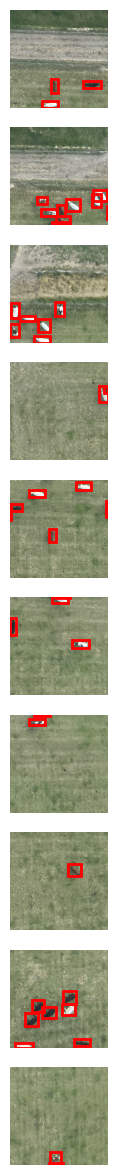

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

n = 10
i = 0
data_iter = iter(val_set)
fig, ax = plt.subplots(n, figsize=(15, 15))
while i < n:
    image, target = next(data_iter)
    
    ax[i].imshow(np.transpose(image.numpy(), (1, 2, 0)) / 255.0)

    for box in target["boxes"]:
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        rectangle = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax[i].add_patch(rectangle)

      # Turn off axis labels
    ax[i].axis('off')
    i += 1
    
plt.show()
#plt.savefig("wrong.png")

In [6]:
torch.save(train_set, "data/train_set.pkl")
torch.save(test_set, "data/test_set.pkl")
torch.save(val_set, "data/val_set.pkl")